# Segmenting a Database Retrospectively

## Computing RFM

In [2]:
# import needed packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import squarify
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [3]:
from pandasql import sqldf

In [3]:
# Set notebook environment
pysqldf = lambda q: sqldf(q, globals())
%precision %.2f
pd.options.display.float_format = "{:,.2f}".format
plt.rcParams["figure.figsize"] = 10, 8

In [4]:
# Load text file into a local variable
columns = ["customer_id", "purchase_amount", "date_of_purchase"]
df = pd.read_csv("purchases.txt", header=None, sep="\t", names=columns)
df.sample(n=5, random_state=57)

,customer_id,purchase_amount,date_of_purchase
4510,8060,30.00,2014-12-24
17761,109180,50.00,2009-11-25
39110,9830,30.00,2007-06-12
37183,56400,60.00,2009-09-30
33705,41290,60.00,2007-08-21


In [5]:
# interpret the last column as datetime
df["date_of_purchase"] = pd.to_datetime(df["date_of_purchase"], format="%Y-%m-%d")
# Extract year of purchase and save it as a column
df["year_of_purchase"] = df["date_of_purchase"].dt.year
df.head()

,customer_id,purchase_amount,date_of_purchase,year_of_purchase
0,760,25.00,2009-11-06,2009
1,860,50.00,2012-09-28,2012
2,1200,100.00,2005-10-25,2005
3,1420,50.00,2009-07-09,2009
4,1940,70.00,2013-01-25,2013


In [6]:
# Add a day_since column showing the difference between last purchase and a basedate
basedate = pd.Timestamp("2016-01-01")
df["days_since"] = (basedate - df["date_of_purchase"]).dt.days

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51243 entries, 0 to 51242
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       51243 non-null  int64         
 1   purchase_amount   51243 non-null  float64       
 2   date_of_purchase  51243 non-null  datetime64[ns]
 3   year_of_purchase  51243 non-null  int64         
 4   days_since        51243 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.0 MB


## 2014 - Data

In [8]:
# Compute RFM variables as of a year ago using SQL
q = """
        SELECT customer_id,
        MIN(days_since) - 365 AS 'recency',
        MAX(days_since) - 365 AS 'first_purchase',
        COUNT(*) AS 'frequency',
        AVG(purchase_amount) AS 'amount'
        FROM df
        WHERE days_since > 365
        GROUP BY 1"""

customers_2014 = sqldf(q)

In [9]:
customers_2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16905 entries, 0 to 16904
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     16905 non-null  int64  
 1   recency         16905 non-null  int64  
 2   first_purchase  16905 non-null  int64  
 3   frequency       16905 non-null  int64  
 4   amount          16905 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 660.5 KB


In [10]:
customers_2014.loc[customers_2014["recency"] > 365 * 3, "segment"] = "inactive"
customers_2014["segment"] = customers_2014["segment"].fillna("NA")
customers_2014.loc[
    (customers_2014["recency"] <= 365 * 3) & (customers_2014["recency"] > 356 * 2),
    "segment",
] = "cold"
customers_2014.loc[
    (customers_2014["recency"] <= 365 * 2) & (customers_2014["recency"] > 365 * 1),
    "segment",
] = "warm"
customers_2014.loc[customers_2014["recency"] <= 365, "segment"] = "active"
customers_2014.loc[
    (customers_2014["segment"] == "warm")
    & (customers_2014["first_purchase"] <= 365 * 2),
    "segment",
] = "new warm"
customers_2014.loc[
    (customers_2014["segment"] == "warm") & (customers_2014["amount"] < 100), "segment"
] = "warm low value"

customers_2014.loc[
    (customers_2014["segment"] == "warm") & (customers_2014["amount"] >= 100), "segment"
] = "warm high value"
customers_2014.loc[
    (customers_2014["segment"] == "active") & (customers_2014["first_purchase"] <= 365),
    "segment",
] = "new active"

customers_2014.loc[
    (customers_2014["segment"] == "active") & (customers_2014["amount"] < 100),
    "segment",
] = "active low value"

customers_2014.loc[
    (customers_2014["segment"] == "active") & (customers_2014["amount"] >= 100),
    "segment",
] = "active high value"

In [11]:
customers_2014["segment"].value_counts()

inactive             7512
active low value     3011
cold                 2153
new active           1437
new warm             1250
warm low value        956
active high value     475
warm high value       111
Name: segment, dtype: int64

In [12]:
customers_2014.iloc[:, 1:].describe().loc[["mean", "std", "75%", "max"]]

,recency,first_purchase,frequency,amount
mean,"1,122.59","1,788.41",2.66,55.53
std,964.81,"1,024.34",2.72,144.49
75%,"1,868.00","2,695.00",3.00,50.00
max,"3,649.00","3,651.00",40.00,"4,500.00"


In [13]:
customers_2014.head()

,customer_id,recency,first_purchase,frequency,amount,segment
0,10,3464,3464,1,30.00,inactive
1,80,302,3386,6,70.00,active low value
2,90,393,3418,10,115.80,warm high value
3,120,1036,1036,1,20.00,cold
4,130,2605,3345,2,50.00,inactive


In [14]:
# Transform segment column datatype from object to category
customers_2014["segment"] = customers_2014["segment"].astype("category")

In [15]:
# Re-order segments in a better readable way
sorter = [
    "inactive",
    "cold",
    "warm high value",
    "warm low value",
    "new warm",
    "active high value",
    "active low value",
    "new active",
]
customers_2014.segment.cat.set_categories(sorter, inplace=True)
customers_2014.sort_values(["segment"])

,customer_id,recency,first_purchase,frequency,amount,segment
0,10,3464,3464,1,30.00,inactive
6872,108170,2261,2261,1,20.00,inactive
6873,108180,1693,2261,2,20.00,inactive
6874,108190,2261,2261,1,30.00,inactive
6875,108200,2107,2261,3,36.67,inactive
...,...,...,...,...,...,...
15939,221470,236,236,1,15.00,new active
15938,221460,236,236,1,30.00,new active
15937,221450,236,236,1,45.00,new active
15935,221430,236,236,1,45.00,new active


In [16]:
c2014 = pd.DataFrame(customers_2014["segment"].value_counts())

(0.0, 100.0, 0.0, 100.0)

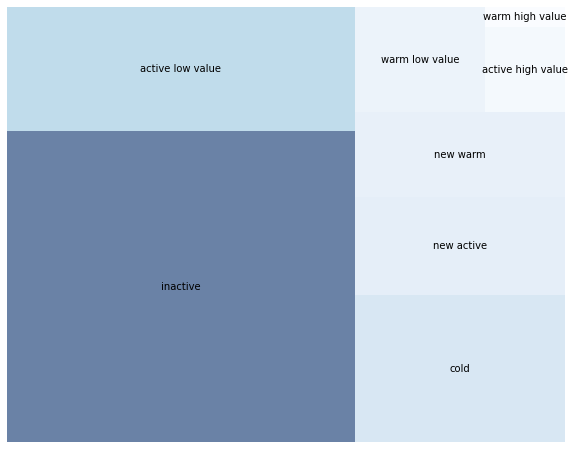

In [17]:
norm = mpl.colors.Normalize(vmin=min(c2014["segment"]), vmax=max(c2014["segment"]))
colors = [mpl.cm.Blues(norm(value)) for value in c2014["segment"]]
squarify.plot(sizes=c2014["segment"], label=c2014.index, color=colors, alpha=0.6)
plt.axis("off")

## 2015 - Data

In [18]:
# Compute revenues generated by customers in 2015 using SQL
q = """
        SELECT customer_id, 
        SUM(purchase_amount) AS 'revenue_2015'
        FROM df
        WHERE year_of_purchase = 2015
        GROUP BY 1
    """
revenue_2015 = sqldf(q)

In [19]:
q = """
        SELECT customer_id,
        MIN(days_since) AS 'recency',
        MAX(days_since) AS 'first_purchase',
        COUNT(*) AS 'frequency',
        AVG(purchase_amount) AS 'amount'
        FROM df GROUP BY 1"""
customers_2015 = sqldf(q)

In [20]:
revenue_2015.shape[0]

5398

In [21]:
customers_2015.shape[0]

18417

In [22]:
customers_2015.loc[customers_2015["recency"] > 365 * 3, "segment"] = "inactive"
customers_2015["segment"] = customers_2015["segment"].fillna("NA")
customers_2015.loc[
    (customers_2015["recency"] <= 365 * 3) & (customers_2015["recency"] > 356 * 2),
    "segment",
] = "cold"
customers_2015.loc[
    (customers_2015["recency"] <= 365 * 2) & (customers_2015["recency"] > 365 * 1),
    "segment",
] = "warm"
customers_2015.loc[customers_2015["recency"] <= 365, "segment"] = "active"
customers_2015.loc[
    (customers_2015["segment"] == "warm")
    & (customers_2015["first_purchase"] <= 365 * 2),
    "segment",
] = "new warm"
customers_2015.loc[
    (customers_2015["segment"] == "warm") & (customers_2015["amount"] < 100), "segment"
] = "warm low value"
customers_2015.loc[
    (customers_2015["segment"] == "warm") & (customers_2015["amount"] >= 100), "segment"
] = "warm high value"
customers_2015.loc[
    (customers_2015["segment"] == "active") & (customers_2015["first_purchase"] <= 365),
    "segment",
] = "new active"
customers_2015.loc[
    (customers_2015["segment"] == "active") & (customers_2015["amount"] < 100),
    "segment",
] = "active low value"
customers_2015.loc[
    (customers_2015["segment"] == "active") & (customers_2015["amount"] >= 100),
    "segment",
] = "active high value"

In [23]:
# Transform segment column datatype from object to category
customers_2015["segment"] = customers_2015["segment"].astype("category")
# Re-order segments in a better readable way
sorter = [
    "inactive",
    "cold",
    "warm high value",
    "warm low value",
    "new warm",
    "active high value",
    "active low value",
    "new active",
]
customers_2015.segment.cat.set_categories(sorter, inplace=True)
customers_2015.sort_values(["segment"], inplace=True)

,customer_id,recency,first_purchase,frequency,amount,segment
0,10,3829,3829,1,30.00,inactive
7894,119690,1500,2443,4,30.00,inactive
7895,119710,2249,2443,3,26.67,inactive
7896,119720,2156,2443,2,40.00,inactive
7897,119730,2443,2443,1,50.00,inactive
...,...,...,...,...,...,...
17404,252380,73,73,1,10.00,new active
17403,252370,73,73,1,45.00,new active
17402,252360,73,73,1,20.00,new active
17411,252450,72,72,1,45.00,new active


In [24]:
# Merge 2015 customers and 2015 revenue, while making sure that customers
# without purchase in 2015 also appear in the new df
actual = customers_2015.merge(revenue_2015, how="left", on="customer_id")
actual.describe()

,customer_id,recency,first_purchase,frequency,amount,revenue_2015
count,"18,417.00","18,417.00","18,417.00","18,417.00","18,417.00","5,398.00"
mean,"137,573.51","1,253.04","1,984.01",2.78,57.79,88.62
std,"69,504.60","1,081.44","1,133.41",2.94,154.36,224.36
min,10.00,1.00,1.00,1.00,5.00,5.00
25%,"81,990.00",244.00,988.00,1.00,21.67,30.00
50%,"136,430.00","1,070.00","2,087.00",2.00,30.00,50.00
75%,"195,100.00","2,130.00","2,992.00",3.00,50.00,85.00
max,"264,200.00","4,014.00","4,016.00",45.00,"4,500.00","4,500.00"


In [25]:
actual.head()

,customer_id,recency,first_purchase,frequency,amount,segment,revenue_2015
0,10,3829,3829,1,30.00,inactive,NaN
1,80,343,3751,7,71.43,active low value,80.00
2,90,758,3783,10,115.80,cold,NaN
3,120,1401,1401,1,20.00,inactive,NaN
4,130,2970,3710,2,50.00,inactive,NaN


In [26]:
# Replace NaNs in the revenus_2015 column with 0s
actual["revenue_2015"].fillna(0, inplace=True)
actual.head()

,customer_id,recency,first_purchase,frequency,amount,segment,revenue_2015
0,10,3829,3829,1,30.00,inactive,0.00
1,80,343,3751,7,71.43,active low value,80.00
2,90,758,3783,10,115.80,cold,0.00
3,120,1401,1401,1,20.00,inactive,0.00
4,130,2970,3710,2,50.00,inactive,0.00


In [27]:
actual[["revenue_2015", "segment"]].groupby("segment").mean()

,revenue_2015
segment,
inactive,0.00
cold,0.00
warm high value,0.00
warm low value,0.00
new warm,0.00
active high value,323.57
active low value,52.31
new active,79.17


By definition inactive, warm and cold didn't generate any revenue in the same year we are investigating. That's why the 0.00 in these rows.

## Computing Predictors and Target Variables



In [28]:
# Merge 2014 customers and 2015 revenue
forward = customers_2014.merge(revenue_2015, how="left", on="customer_id")
forward.head()

,customer_id,recency,first_purchase,frequency,amount,segment,revenue_2015
0,10,3464,3464,1,30.00,inactive,NaN
1,80,302,3386,6,70.00,active low value,80.00
2,90,393,3418,10,115.80,warm high value,NaN
3,120,1036,1036,1,20.00,cold,NaN
4,130,2605,3345,2,50.00,inactive,NaN


In [29]:
# Replace NaNs in the revenus_2015 column with 0s
forward["revenue_2015"].fillna(0, inplace=True)

In [30]:
r = forward[["revenue_2015", "segment"]].groupby("segment").mean()

In [31]:
r.sort_values(by=["revenue_2015"], ascending=False, inplace=True)

<AxesSubplot:xlabel='segment'>

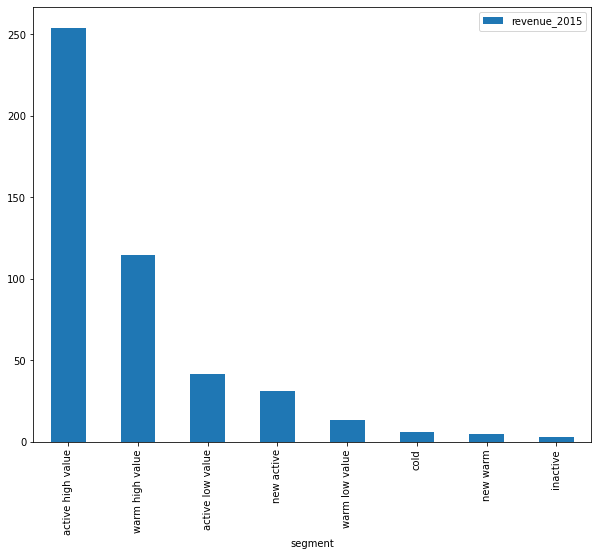

In [32]:
r.plot.bar()

As we can see, customers classified as "active high value" in 2014 are the most revenue generating in 2015 and in the second place comes customers from the "warm high value"

## Quiz

In [33]:
actual["segment"].value_counts()

inactive             9158
active low value     3313
cold                 1903
new active           1512
new warm              938
warm low value        901
active high value     573
warm high value       119
Name: segment, dtype: int64

In [34]:
# How many "new active low" (active low value) customers were there in 2015?

(actual["segment"] == "active low value").sum()

3313

In [35]:
# The number of "new active high" customers has increased between 2014 and 2015.
# What is the rate of that increase?

ne = (customers_2015["segment"] == "active high value").sum()
ol = (customers_2014["segment"] == "active high value").sum()

print("%.2f" % ((ne - ol) / ol * 100))

20.63


In [36]:
print("{:.2f}".format((ne - ol) / ol * 100))

20.63


In [37]:
print(f"{(ne - ol)/ol * 100}")

20.63157894736842


# Building a Predictive Model

In [38]:
q = """
        SELECT customer_id, 
        MIN(days_since) - 365 AS 'recency', 
        MAX(days_since) - 365 AS 'first_purchase', 
        COUNT(*) AS 'frequency', 
        AVG(purchase_amount) AS 'avg_amount', 
        MAX(purchase_amount) AS 'max_amount' 
        FROM df WHERE days_since > 365 GROUP BY 1
"""
customers_2014 = sqldf(q, globals())

In [39]:
q = """
        SELECT customer_id, 
        SUM(purchase_amount) AS 'revenue_2015' 
        FROM df WHERE year_of_purchase = 2015 
        GROUP BY 1
"""
revenue_2015 = sqldf(q, globals())

In [40]:
# Merge 2014 customers with 2015 revenue
in_sample = customers_2014.merge(revenue_2015, how="left", on="customer_id")
in_sample["revenue_2015"].fillna(0, inplace=True)
in_sample.loc[in_sample["revenue_2015"] > 0, "active_2015"] = 1

In [41]:
in_sample["active_2015"].fillna(0, inplace=True)
in_sample["active_2015"] = in_sample["active_2015"].astype("int")
in_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16905 entries, 0 to 16904
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     16905 non-null  int64  
 1   recency         16905 non-null  int64  
 2   first_purchase  16905 non-null  int64  
 3   frequency       16905 non-null  int64  
 4   avg_amount      16905 non-null  float64
 5   max_amount      16905 non-null  float64
 6   revenue_2015    16905 non-null  float64
 7   active_2015     16905 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 1.2 MB


------

## The Likelihood a Customer will be Active in 2015

Now, we are going to calibrate the first model, which is the probability model. The likelihood that a customer we'd be active in 2015 or not. 

* the output of the model which I call prob dot model is the output of the Multinom function with formula that states that active 2015 is a function of recency first purchase as frequency, average amount and maximum amount.
* And the data is the data we created the calibration data called In sample.

These will fit, calibrate the entire model on the data set. And then we can going to extract the coefficients and the standard deviations of these coefficients, and output not only the coefficients, the standard deviations, but the ratio of those as well.

In [42]:
# We use the Logit function since the output could be either 0 or 1
prob_model = sm.Logit.from_formula(
    "active_2015 ~ recency + first_purchase + frequency + avg_amount + max_amount",
    in_sample,
)
prob_model_fit = prob_model.fit()
coef = prob_model_fit.params
std = prob_model_fit.bse

Optimization terminated successfully.
         Current function value: 0.365836
         Iterations 8


In [43]:
print(coef)

Intercept        -0.53
recency          -0.00
first_purchase   -0.00
frequency         0.22
avg_amount        0.00
max_amount       -0.00
dtype: float64


In [44]:
print(std)

Intercept        0.04
recency          0.00
first_purchase   0.00
frequency        0.01
avg_amount       0.00
max_amount       0.00
dtype: float64


In [45]:
print(coef / std)

Intercept        -12.09
recency          -32.75
first_purchase    -0.30
frequency         14.84
avg_amount         1.14
max_amount        -0.57
dtype: float64


The model converged! 👍

The recency parameter, for instance, it's negative. Which makes perfect sense. The larger the recency, meaning the more days have lapsed between the last purchase and today, the less likely you're going to make any other purchase in the future.

So, if your last purchase was three four ten years ago, it's extremely unlikely that you'll make any purchase very soon. Meaning that the sign of the primary is negative, the higher the recency, the lower the probability.

if you look at frequency, that primary is positive. Meaning that the more purchases you've made in the past, the more likely you'll make additional purchases in the future, which makes perfect sense. Now, these two parameter values are the most interesting, simply because if you look at standard deviations and at the ratio between coefficients and standard deviation, which usually indicate to what extent each parameter value is significant, or not. If it's above two, or below minus two, usually it's a good sign, and as you can see here, recently is huge, minus 32

## Monetary Prediction Model



In [46]:
# For the monetary model, we select only those who made a purchase
# Only the index are enough
z = in_sample[in_sample["active_2015"] == 1].index.tolist()

In [47]:
z[:5]

[1, 17, 29, 30, 31]

In [48]:
in_sample.loc[z].describe()

,customer_id,recency,first_purchase,frequency,avg_amount,max_amount,revenue_2015,active_2015
count,"3,886.00","3,886.00","3,886.00","3,886.00","3,886.00","3,886.00","3,886.00","3,886.00"
mean,"134,906.97",306.35,"1,636.16",4.74,67.78,88.33,92.30,1.00
std,"68,404.30",519.46,"1,101.25",3.79,160.06,222.15,217.45,0.00
min,80.00,1.00,1.00,1.00,5.00,5.00,5.00,1.00
25%,"78,590.00",23.00,649.75,2.00,30.00,30.00,30.00,1.00
50%,"143,550.00",97.00,"1,604.00",4.00,40.00,50.00,50.00,1.00
75%,"194,362.50",328.00,"2,666.00",7.00,60.00,80.00,100.00,1.00
max,"236,660.00","3,544.00","3,647.00",40.00,"4,500.00","4,500.00","4,500.00",1.00


We only have active customers in there. In terms of revenue, customers have spent anything between \\$5 and \\$4500 with that retailer of the year 2015. Now, what you are going to do is calibrate the monetary model. Meaning we begin to predict how much they spend in 2015 based on only two things here, the average amount they spend usually, and the maximum amount they spend. So we have two different predictors.

SM, which stands for Linear Model, will fit a linear model to match as closely as we can revenue 2015 based on the predictor's average amount and maximum amount. And the data here is not the entire sample, but only those customers who can be found in the index, Z here. So only those customers who actually spend something.

In [49]:
# Calibrate the monetary model (version 1)
amount_model = sm.OLS.from_formula(
    "revenue_2015 ~ avg_amount + max_amount", in_sample.loc[z]
)
amount_model_fit = amount_model.fit()
amount_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           revenue_2015   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     2979.
Date:                Thu, 22 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:00:27   Log-Likelihood:                -24621.
No. Observations:                3886   AIC:                         4.925e+04
Df Residuals:                    3883   BIC:                         4.927e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.7471      2.381      8.713      0.000      16.079      25.415
avg_amount     0.6749      0.033     20.575      0.000       0.611       0.739
max_amount     0.2923      0.024     12.367      0.000       0.246       0.339
==============================================================================
Omnibus:                     5580.836   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8162692.709
Skew:                           7.843   Prob(JB):                         0.00
Kurtosis:                     226.980   Cond. No.                         315.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our square value is point 60, which is basically a signal of the fit of the model. But, we have a slight issue here.

If we plot on one hand how much has been spent by customers and on the other we take the amount model we've just created through linear regression, and look at the fitted values, we get an ugly chart. And the reason is that most customers have spent small amounts and a few outliers have spent huge amounts, up to \$4.000.

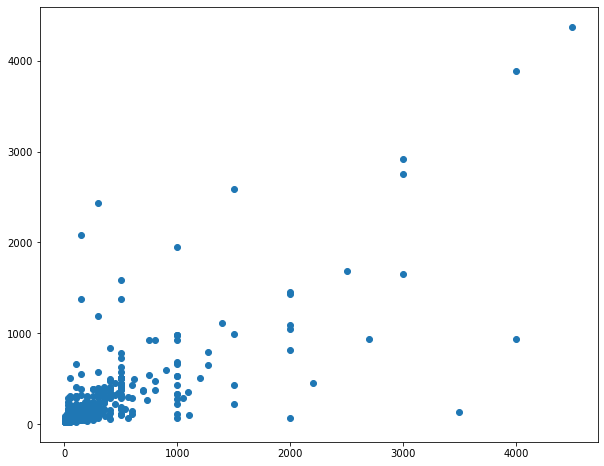

In [50]:
plt.scatter(in_sample.loc[z].revenue_2015, amount_model_fit.fittedvalues)

So for optimization purposes, instead of creating a model with the amount we're going to create an amount with logaritmic distribution.

So instead of predicting revenue 2015 bsed on average amount and maximum amount. We're going to predict the log of revenue 2015 based on the log on average

In [51]:
# Re-calibrate the monetary model, using a log-transform (version 2)
amount_model = sm.OLS.from_formula(
    "np.log(revenue_2015) ~ np.log(avg_amount) + np.log(max_amount)", in_sample.loc[z]
)
amount_model_fit = amount_model.fit()
amount_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(revenue_2015)   R-squared:                       0.693
Model:                              OLS   Adj. R-squared:                  0.693
Method:                   Least Squares   F-statistic:                     4377.
Date:                  Thu, 22 Apr 2021   Prob (F-statistic):               0.00
Time:                          15:00:28   Log-Likelihood:                -2644.6
No. Observations:                  3886   AIC:                             5295.
Df Residuals:                      3883   BIC:                             5314.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3700      0.040      9.242      0.000       0.292       0.448
np.log(avg_amount)     0.5488      0.042     13.171      0.000       0.467       0.631
np.log(max_amount)     0.3881      0.038     10.224      0.000       0.314       0.463
==============================================================================
Omnibus:                      501.505   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3328.833
Skew:                           0.421   Prob(JB):                         0.00
Kurtosis:                       7.455   Cond. No.                         42.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R-squared has improved, meaning we fit the data much better.

Now the plot makes much more sense too. Since we put more weight to the smaller values and less weight to the very large values. 

It looks like we could generate a line through the cloud of points predicting the revenue of 2015.

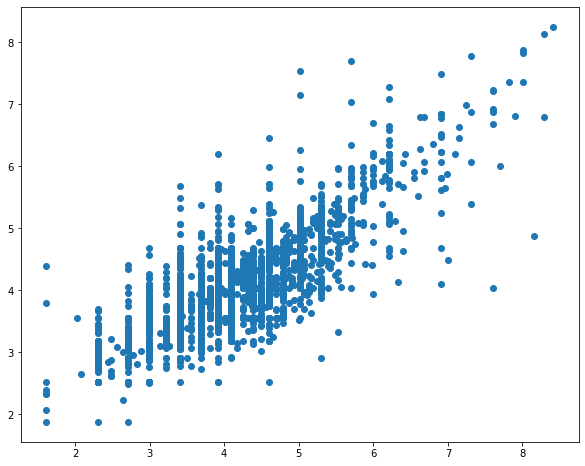

In [52]:
# Plot the results of the monetary model
plt.scatter(np.log(in_sample.loc[z].revenue_2015), amount_model_fit.fittedvalues)

To summarize we have just calibrated two models the first one over here, to predict the likelihood that someone will be active. And the second one over here to predict how much they will spend if they will be active in 2015. 

Now the end game of this exercise is actually to apply the models to predict the future. So what we are going to do is to look at today's behavior, today's data, and extract exactly the same information about today's customers as we used in terms of predictors about a year ago. So we're going to extract recency, first purchase, average amount, maximum amount, and everything else for the 2015 customers about whom of course we have no idea who will be active next year, and how much they'll spend in 2016. But we can try to predict that, with our model, so once you create that and that what is usually called the out of sample data set.

## Apply The Model To Today's Data

In [53]:
# Compute RFM as of Today
q = """
        SELECT customer_id, 
        MIN(days_since) AS 'recency', 
        MAX(days_since) AS 'first_purchase', 
        COUNT(*) AS 'frequency', 
        AVG(purchase_amount) AS 'avg_amount', 
        MAX(purchase_amount) AS 'max_amount' FROM df GROUP BY 1
"""
customers_2015 = sqldf(q, globals())

In [54]:
# Predict the target variables based on today's data
# 1st: we predict the probability that a customer is going to be in 2016 active
customers_2015["prob_predicted"] = prob_model_fit.predict(customers_2015)

# 2nd we predict the revenue
# Since our model predicts the log(amount) we need to take the exponential of
# the predicted revenue generated per customer
customers_2015["revenue_predicted"] = np.exp(amount_model_fit.predict(customers_2015))

# 3rd: we give a score to each customer which is the conjunction of probability
# predicted multiplied by the amount.
customers_2015["score_predicted"] = (
    customers_2015["prob_predicted"] * customers_2015["revenue_predicted"]
)

In [55]:
customers_2015.prob_predicted.describe()

count   18,417.00
mean         0.22
std          0.25
min          0.00
25%          0.01
50%          0.11
75%          0.40
max          1.00
Name: prob_predicted, dtype: float64

In [56]:
customers_2015.revenue_predicted.describe()

count   18,417.00
mean        65.63
std        147.89
min          6.54
25%         29.00
50%         35.05
75%         57.30
max      3,832.95
Name: revenue_predicted, dtype: float64

In [57]:
customers_2015.score_predicted.describe()

count   18,417.00
mean        18.83
std         70.21
min          0.00
25%          0.46
50%          4.56
75%         17.96
max      2,854.16
Name: score_predicted, dtype: float64

So the overall score Is actually a function of both and probability and revenue together. And the score has a mean of 18,8. What does it mean? From a managerial point of view, that value is extremely important. It means that, on the average, every customer in this database, will spend 18 point eight dollar next year.

<AxesSubplot:>

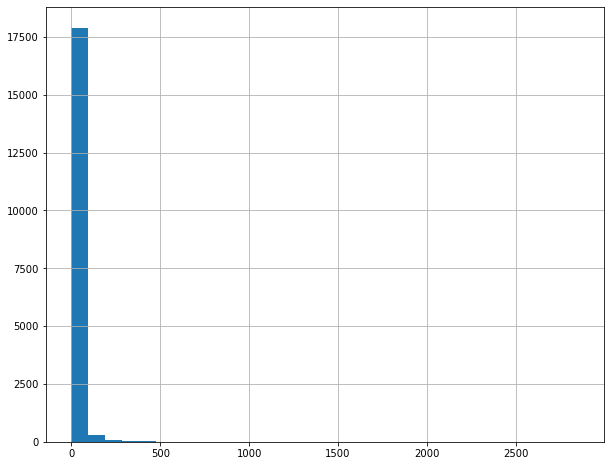

In [58]:
customers_2015.score_predicted.hist(bins=30)

We'll take the customers here. Look at their predict score and only retain those with the score. Above \\$50, and if you look at that, it will create a vector of people with a score above \\$50, which contains a total of 1323 customers. So in the list of 18,000 customers here about 1,300 have a predicted score of \\$50 or more and you can see which ones they are.

In [59]:
# How many customers have an expected revenue of more than $50
z = customers_2015[customers_2015.score_predicted > 50].index.tolist()
print(len(z))

1324


In [60]:
# Customers with the highest score:
customers_2015["customer_id"].loc[z]

2            90
17          480
38         1020
41         1050
42         1150
          ...  
18372    263080
18391    263340
18392    263350
18402    263470
18416    264200
Name: customer_id, Length: 1324, dtype: int64